In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
from PIL import Image
from torchvision.models import vgg19

# controllare

# Load data

In [2]:
def set_seed(seed, use_gpu = True):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 44

USE_SEED = False

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

In [3]:
def load_image(image_path, device, output_size=None):
    """Loads an image by transforming it into a tensor."""
    img = Image.open(image_path)

    output_dim = None
    if output_size is None:
        output_dim = (img.size[1], img.size[0])
    elif isinstance(output_size, int):
        output_dim = (output_size, output_size)
    elif isinstance(output_size, tuple):
        if (len(output_size) == 2) and isinstance(output_size[0], int) and isinstance(output_size[1], int):
            output_dim = output_size
    else:
        raise ValueError("ERROR: output_size must be an integer or a 2-tuple of (height, width) if provided.")

    torch_loader = transforms.Compose(
        [
            transforms.Resize(output_dim),
            transforms.ToTensor()
        ]
    )
    
    img_tensor = torch_loader(img).unsqueeze(0)
    return img_tensor.to(device)

In [4]:
"""Gloria´s paths"""
#content_path = "/home/gloria/Scrivania/Vision_and_cognitive_system/content_style/content.jpg"
#style_path = "/home/gloria/Scrivania/Vision_and_cognitive_system/content_style/style1.jpg"

"""Sara´s paths"""
content_path = "/home/sara/Scrivania/Physics_of_Data/2nd Year/Vision_cognitive_sys/Projects/neural_style_transfer/san-francisco-usa.jpg"
style_path = "/home/sara/Scrivania/Physics_of_Data/2nd Year/Vision_cognitive_sys/Projects/neural_style_transfer/udnie.jpg"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
output_size = 512

content_tensor = load_image(content_path, device, output_size=output_size)
output_size = (content_tensor.shape[2], content_tensor.shape[3])
style_tensor = load_image(style_path, device, output_size=output_size)

In [5]:
print(content_tensor.shape)
print(style_tensor.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [6]:
style_tensor

tensor([[[[0.2314, 0.2627, 0.2941,  ..., 0.3059, 0.2510, 0.1647],
          [0.1804, 0.2157, 0.2471,  ..., 0.2784, 0.2314, 0.1608],
          [0.1255, 0.1529, 0.1843,  ..., 0.2431, 0.2000, 0.1490],
          ...,
          [0.5725, 0.5804, 0.5922,  ..., 0.1294, 0.1725, 0.3608],
          [0.6000, 0.6078, 0.6118,  ..., 0.0745, 0.1098, 0.2824],
          [0.5020, 0.5059, 0.5098,  ..., 0.3451, 0.3451, 0.4824]],

         [[0.2353, 0.2667, 0.2980,  ..., 0.3098, 0.2549, 0.1686],
          [0.1843, 0.2196, 0.2510,  ..., 0.2824, 0.2353, 0.1647],
          [0.1294, 0.1569, 0.1882,  ..., 0.2471, 0.2039, 0.1529],
          ...,
          [0.5333, 0.5412, 0.5529,  ..., 0.1294, 0.1765, 0.3647],
          [0.5608, 0.5686, 0.5725,  ..., 0.0745, 0.1137, 0.2863],
          [0.4627, 0.4667, 0.4706,  ..., 0.3451, 0.3490, 0.4863]],

         [[0.2510, 0.2824, 0.3137,  ..., 0.3294, 0.2745, 0.1882],
          [0.2000, 0.2353, 0.2667,  ..., 0.3020, 0.2549, 0.1843],
          [0.1451, 0.1725, 0.2039,  ..., 0

# VGG model

In [7]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()

        #select 5 convolutional layers
        self.chosen_features = {0: 'conv1_1', 5: 'conv2_1', 10: 'conv3_1', 19: 'conv4_1', 21: 'conv4_2', 28: 'conv5_1'}
        self.vgg = torchvision.models.vgg19(weights='DEFAULT').features[:37]
        
    def forward(self, x):
        feature_maps = dict()
        for idx, layer in enumerate(self.vgg):
            x = layer(x)
            if idx in self.chosen_features.keys():
                feature_maps[self.chosen_features[idx]] = x
        
        return feature_maps



In [8]:
#load the model
vgg = VGG19().to(device).eval()

In [9]:
vgg

VGG19(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

### Structure of VGG
The structure is:
- Conv1:
    - conv 1_1 [0]
    - conv 1_2 [2]
- Conv2:
    - conv 2_1 [5]
    - conv 2_2 [7]
- Conv3:
    - conv 3_1 [10]
    - conv 3_2 [12]
    - conv 3_3 [14]
    - conv 3_4 [16]
- Conv4:
    - conv 4_1 [19]
    - conv 4_2 [21]
    - conv 4_3 [23]
    - conv 4_4 [25]
- Conv5:
    - conv 5_1 [28]
    - conv 5_2 [30]
    - conv 5_3 [32]
    - conv 5_4 [34]
    
We will use:
- For content loss: conv4_2 
- For style loss: conv1_1,conv2_1,conv3_1,conv4_1,conv5_1

# Losses

The overall loss is constituted by the loss of the target image with respect to the content image, and the loss of the target image with respect to the style image. $$L_{tot}=L_{content}+L_{style}$$
For this process it wouldn´t make sense to compare the images pixel by pixel: for example if the content image contains a house and the predominant style of the style image is to have diagonal lines, we would want the target image to be a house which is inclinated diagonally; comparing pixel by pixel an image with a diagonal house and an image with a house would return a much higher loss than we expect, because the pixel by pixel comparison doesn´t take into account more ǵeneric'features
In order to perform a more accurate comparison, both these losses are evaluated between **feature maps** which take into account the more generic features of both images.

### Content loss
The content loss is computed at the end of the CNN; we compute the mean squared error between the target feature map and the content feature map.

In [10]:
def get_content_loss(target_map, content_map):
    #return torch.mean((content_original-content_current)**2)
    return torch.nn.MSELoss(reduction='mean')(target_map, content_map)

### Style loss
For the style loss, the procedure is more complicated.
We are interested in co-occurrences of pairs of features to highlight important stylistic combinations.    

If we have a feature map, of height and width $h,w$ and lenght $k$, which is the number of maps applied, we want to compute cooccurrences between each pair of  maps $i,j$ with values in $[0,k]$ range (these are also called *channels*): we obtain a $kxk$ matrix in which each entry is the dot product between two maps, a scalar.    
Given the feature map of an image, this matrix, called the **Gram matrix** can be computed easily as the sum of the matrix multiplication between the whole feature map and its transpose.
   
This is done both with the feature map of the STYLE IMAGE and the feature map of the TARGET IMAGE.
We compute a Gram matrix for both images for each convolutional layer considered $l$, and end up with:
   - 5 Gram matrices of the style image feature maps $G_{style}^l$
   - 5 Gram matrices of the target image feature maps  $G_{target}^l$    
   
The loss of each layer $l$ is computed via MSE between the two gram matrices, and the overall style loss will be the average of these values over the number of layers (in our case 5).

In [11]:
def get_style_loss(target_map,style_map):
    """Compute MSE between gram matrix of style feature map and of generated feature map as style loss."""
    _, channel, height, width = target_map.shape
    
    #computing Gram matrix of the style feature map
    style_gram = style_map.view(channel, height*width).mm(
        style_map.view(channel, height*width).t()
    )
    #computing Gram matrix of the target feature map
    target_gram = target_map.view(channel, height*width).mm(
        target_map.view(channel, height*width).t()
    )
    # Normalize the Gram matrices
    norm = channel * height * width
    style_gram /= norm
    target_gram /= norm
    
    return torch.mean((target_gram - style_gram) ** 2)



### Total variation loss

In [12]:
def total_variation_loss(image):
    loss = torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
           torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
    return loss

# Training

### Initialize random (target) image

In [13]:
img=content_tensor
img.shape 

#gaussian_noise_img = np.random.normal(loc=0, scale=90., size=img.shape).astype(np.float32)
white_noise_img = np.random.uniform(-90., 90., img.shape).astype(np.float32)
init_img = torch.from_numpy(white_noise_img).float().to(device)
init_img = (init_img - init_img.min()) / (init_img.max() - init_img.min())
init_img.shape

torch.Size([1, 3, 512, 512])

In this case, renormalized images are used in the CNN, but to visualize the actual images we have to denormalize them

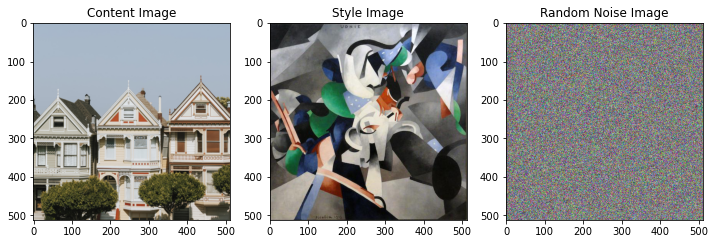

In [14]:
content_show = transforms.ToPILImage()(torchvision.utils.make_grid(content_tensor.cpu()))
style_show = transforms.ToPILImage()(torchvision.utils.make_grid(style_tensor.cpu()))
rnd_show = transforms.ToPILImage()(torchvision.utils.make_grid(init_img.cpu()))


# Display the original content, style image, and random noise images
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(content_show)
axs[0].set_title("Content Image")

axs[1].imshow(style_show)
axs[1].set_title("Style Image")

axs[2].imshow(rnd_show)
axs[2].set_title("Random Noise Image")

plt.show()

### Utils

In [14]:

def save_content_features(content, model, layer_indices, intermediate_dir):
    with torch.no_grad():
        content_features = model(content)

        for layer_idx in layer_indices:
            layer_name = model.chosen_features[layer_idx]
            feature_map = content_features[layer_name].squeeze(0)
            
            # Normalizza il tensore
            normalized_feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
            
            # Converte la feature map in un'immagine utilizzando matplotlib
            plt.imshow(normalized_feature_map[0].cpu().numpy(), cmap='viridis')
            plt.axis('off')
            
            # Salva l'immagine
            save_path = os.path.join(intermediate_dir, f'content_{layer_idx}.jpg')
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            plt.close()



### Parameters

In [15]:
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
content_layers = ['conv4_2']

In [16]:
content = content_tensor
style = style_tensor
target = init_img.requires_grad_(True)  #requires_grad is needed to make sure that the image is updated


learn_rate=0.1
alpha=5.0
beta=6e6
tv_weight=0.0


from torchvision.utils import save_image
intermediate_dir="/home/sara/Scrivania/Physics_of_Data/2nd Year/Vision_cognitive_sys/Projects/neural_style_transfer/intermediate"

In [17]:
def train_image(content, style, target, device, output_img_fmt, content_img_name, style_img_name, num_epochs,
               learn_rate):
    """Update the output image using pre-trained VGG19 model."""
    ...
    
    model = VGG19().to(device).eval()    # freeze parameters in the model

    optimizer = torch.optim.Adam([target], lr=learn_rate)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    
    for epoch in range(num_epochs):
        # get features maps of content, style and generated images from chosen layers
        content_features = model(content)
        style_features = model(style)
        target_features = model(target)
        
        content_loss  = 0.0
        style_loss= 0.0
        
        
        """Computing loss"""
        for layer in target_features.keys(): 
            content_feature = content_features[layer]
            style_feature = style_features[layer]
            target_feature = target_features[layer]
   
            
            if layer in content_layers:
            # computes content loss on layer 4_2
                content_loss_per_feature = get_content_loss(content_feature, target_feature)
                content_loss += content_loss_per_feature
                
            if layer in style_layers:
            # computes style loss for all 5 style layers
                style_loss_per_feature = get_style_loss(style_feature, target_feature)
                style_loss+=style_loss_per_feature
        
        #average style loss over all 5 layers
        style_loss /= len(style_layers)
        
        tv_loss = total_variation_loss(target)
        
        # Total loss 
        total_loss = alpha * content_loss + beta * style_loss + tv_weight * tv_loss

      #compute the gradient and update parameters
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #update learning rate
        #scheduler.step()
        
        #Save every 100 steps
        if ((epoch+1)%50)==0:
            save_image(target, os.path.join(intermediate_dir, f'nst-{content_img_name}-{style_img_name}-{epoch + 1}.{output_img_fmt}'))
            
            '''If we used the renormalization, we have to denormalize before saving for visualization purposes'''
            #denormalized_target = denormalize(target.cpu().squeeze()).clamp(0, 1)
            # Save the denormalized image
            #save_image(denormalized_target, os.path.join(intermediate_dir, f'nst-denorm-{content_img_name}-{style_img_name}-{epoch + 1}.{output_img_fmt}'))

        #current_lr = optimizer.param_groups[0]['lr']

        print(f"\tEpoch {epoch + 1}/{num_epochs}, loss = {total_loss}") #last_lr: {current_lr}")
    ...

    return 1

In [18]:
train_image(content, style, target, device,'jpeg', 'house', 'udnie',1000,learn_rate)

	Epoch 1/1000, loss = 342.0003662109375
	Epoch 2/1000, loss = 133.380859375
	Epoch 3/1000, loss = 123.91664123535156
	Epoch 4/1000, loss = 107.66159057617188
	Epoch 5/1000, loss = 102.40156555175781
	Epoch 6/1000, loss = 101.11331176757812
	Epoch 7/1000, loss = 99.36720275878906
	Epoch 8/1000, loss = 97.33504486083984
	Epoch 9/1000, loss = 94.47901916503906
	Epoch 10/1000, loss = 91.11489868164062
	Epoch 11/1000, loss = 87.65605163574219
	Epoch 12/1000, loss = 84.24240112304688
	Epoch 13/1000, loss = 80.9004135131836
	Epoch 14/1000, loss = 77.66868591308594
	Epoch 15/1000, loss = 74.5308609008789
	Epoch 16/1000, loss = 71.48651123046875
	Epoch 17/1000, loss = 68.566162109375
	Epoch 18/1000, loss = 65.76780700683594
	Epoch 19/1000, loss = 63.081199645996094
	Epoch 20/1000, loss = 60.50525665283203
	Epoch 21/1000, loss = 58.03646469116211
	Epoch 22/1000, loss = 55.67527770996094
	Epoch 23/1000, loss = 53.41844177246094
	Epoch 24/1000, loss = 51.264129638671875
	Epoch 25/1000, loss = 49.2

	Epoch 198/1000, loss = 7.936645030975342
	Epoch 199/1000, loss = 7.694601058959961
	Epoch 200/1000, loss = 7.749833106994629
	Epoch 201/1000, loss = 7.574099540710449
	Epoch 202/1000, loss = 7.6000518798828125
	Epoch 203/1000, loss = 7.48362922668457
	Epoch 204/1000, loss = 7.582275390625
	Epoch 205/1000, loss = 7.504737377166748
	Epoch 206/1000, loss = 7.768044471740723
	Epoch 207/1000, loss = 7.54078483581543
	Epoch 208/1000, loss = 7.718823432922363
	Epoch 209/1000, loss = 7.505695819854736
	Epoch 210/1000, loss = 7.619974136352539
	Epoch 211/1000, loss = 7.483389854431152
	Epoch 212/1000, loss = 7.614553451538086
	Epoch 213/1000, loss = 7.55376672744751
	Epoch 214/1000, loss = 7.92616605758667
	Epoch 215/1000, loss = 7.716105937957764
	Epoch 216/1000, loss = 8.06668472290039
	Epoch 217/1000, loss = 7.774660587310791
	Epoch 218/1000, loss = 7.950743198394775
	Epoch 219/1000, loss = 7.792359352111816
	Epoch 220/1000, loss = 7.943821907043457
	Epoch 221/1000, loss = 7.803262233734131

	Epoch 394/1000, loss = 7.970614910125732
	Epoch 395/1000, loss = 7.742604732513428
	Epoch 396/1000, loss = 7.884091854095459
	Epoch 397/1000, loss = 7.725057601928711
	Epoch 398/1000, loss = 7.9188103675842285
	Epoch 399/1000, loss = 7.7704973220825195
	Epoch 400/1000, loss = 8.109540939331055
	Epoch 401/1000, loss = 7.857391834259033
	Epoch 402/1000, loss = 8.161846160888672
	Epoch 403/1000, loss = 7.877481937408447
	Epoch 404/1000, loss = 8.09217643737793
	Epoch 405/1000, loss = 7.869943618774414
	Epoch 406/1000, loss = 8.018169403076172
	Epoch 407/1000, loss = 7.851463794708252
	Epoch 408/1000, loss = 8.013047218322754
	Epoch 409/1000, loss = 7.871695518493652
	Epoch 410/1000, loss = 8.097840309143066
	Epoch 411/1000, loss = 7.866128921508789
	Epoch 412/1000, loss = 8.032440185546875
	Epoch 413/1000, loss = 7.792171478271484
	Epoch 414/1000, loss = 7.904396057128906
	Epoch 415/1000, loss = 7.731560707092285
	Epoch 416/1000, loss = 7.852889060974121
	Epoch 417/1000, loss = 7.7275466

	Epoch 590/1000, loss = 8.208356857299805
	Epoch 591/1000, loss = 7.952703952789307
	Epoch 592/1000, loss = 8.193866729736328
	Epoch 593/1000, loss = 7.988603591918945
	Epoch 594/1000, loss = 8.246110916137695
	Epoch 595/1000, loss = 8.040145874023438
	Epoch 596/1000, loss = 8.377355575561523
	Epoch 597/1000, loss = 8.048858642578125
	Epoch 598/1000, loss = 8.224324226379395
	Epoch 599/1000, loss = 8.017837524414062
	Epoch 600/1000, loss = 8.151925086975098
	Epoch 601/1000, loss = 7.978185176849365
	Epoch 602/1000, loss = 8.146489143371582
	Epoch 603/1000, loss = 7.995988845825195
	Epoch 604/1000, loss = 8.27286148071289
	Epoch 605/1000, loss = 8.021851539611816
	Epoch 606/1000, loss = 8.215155601501465
	Epoch 607/1000, loss = 7.964137077331543
	Epoch 608/1000, loss = 8.087593078613281
	Epoch 609/1000, loss = 7.921584129333496
	Epoch 610/1000, loss = 8.082751274108887
	Epoch 611/1000, loss = 7.928088188171387
	Epoch 612/1000, loss = 8.222270011901855
	Epoch 613/1000, loss = 7.944880008

	Epoch 786/1000, loss = 8.204010009765625
	Epoch 787/1000, loss = 7.948640823364258
	Epoch 788/1000, loss = 8.068280220031738
	Epoch 789/1000, loss = 7.884905815124512
	Epoch 790/1000, loss = 8.056349754333496
	Epoch 791/1000, loss = 7.870656490325928
	Epoch 792/1000, loss = 8.137187957763672
	Epoch 793/1000, loss = 7.892265319824219
	Epoch 794/1000, loss = 8.11408805847168
	Epoch 795/1000, loss = 7.902291297912598
	Epoch 796/1000, loss = 8.06567668914795
	Epoch 797/1000, loss = 7.898447036743164
	Epoch 798/1000, loss = 8.086400032043457
	Epoch 799/1000, loss = 7.9537811279296875
	Epoch 800/1000, loss = 8.212080001831055
	Epoch 801/1000, loss = 7.96442985534668
	Epoch 802/1000, loss = 8.170195579528809
	Epoch 803/1000, loss = 7.92885160446167
	Epoch 804/1000, loss = 8.100553512573242
	Epoch 805/1000, loss = 7.913313865661621
	Epoch 806/1000, loss = 8.127910614013672
	Epoch 807/1000, loss = 7.96653938293457
	Epoch 808/1000, loss = 8.253349304199219
	Epoch 809/1000, loss = 7.998950958251

	Epoch 982/1000, loss = 8.269339561462402
	Epoch 983/1000, loss = 8.032752990722656
	Epoch 984/1000, loss = 8.292997360229492
	Epoch 985/1000, loss = 8.058914184570312
	Epoch 986/1000, loss = 8.214311599731445
	Epoch 987/1000, loss = 8.058097839355469
	Epoch 988/1000, loss = 8.212393760681152
	Epoch 989/1000, loss = 8.052999496459961
	Epoch 990/1000, loss = 8.248920440673828
	Epoch 991/1000, loss = 8.078832626342773
	Epoch 992/1000, loss = 8.287514686584473
	Epoch 993/1000, loss = 8.058114051818848
	Epoch 994/1000, loss = 8.296708106994629
	Epoch 995/1000, loss = 8.070173263549805
	Epoch 996/1000, loss = 8.349824905395508
	Epoch 997/1000, loss = 8.116241455078125
	Epoch 998/1000, loss = 8.357276916503906
	Epoch 999/1000, loss = 8.109268188476562
	Epoch 1000/1000, loss = 8.312661170959473


1

In [ ]:
#save_image(content, os.path.join(intermediate_dir, 'content_after.jpg'))
#save_image(style, os.path.join(intermediate_dir, 'style_after.jpg'))